## ライブラリのインポート

In [89]:
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
#
import stationNumber as station
import numpy as np
import matplotlib.dates as mdates
from metpy.units import units
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
#

## ★アメダス地点と期間の設定★

In [90]:
# flg_kisyoudai = False  # True:気象台・測候所、False:アメダス
#
# アメダス地点の設定 （都道府県・振興局 表示番号、国際地点番号）
# prec_no, block_no, flg_kisyoudai = '42', '47624', True # 群馬県、前橋
# prec_no, block_no, flg_kisyoudai = '42', '0356', False # 群馬県、館林
prec_no, block_no, flg_kisyoudai = '42', '1021', False # 群馬県、伊勢崎
# prec_no, block_no, flg_kisyodai  = '43', '47626', True # 埼玉県、熊谷
# prec_no, block_no, flg_kisyoudai  = '43', '0363', False # 埼玉県、さいたま
# prec_no, block_no, flg_kisyoudai = '40', '47646', True # 茨城、つくば（館野）
# prec_no, block_no, flg_kisyoudai = '44', '47662', True # 東京、東京
# prec_no = '52' # 都府県・振興局表示番号　※52:岐阜県
# block_no = '47632' # 国際地点番号　※47632:岐阜
# prec_no = '56' # 都府県・振興局表示番号　※56:石川県
# block_no = '47600' # 国際地点番号　※47600:輪島
# prec_no = '46' # 都府県・振興局表示番号　※46:神奈川県
# block_no = '47670' # 国際地点番号　※47670:横浜
# prec_no = '50' # 都府県・振興局表示番号　※50:静岡県
# block_no = '47666' # 国際地点番号　※47666:石廊崎
# block_no = '47656' # 国際地点番号　※47656:静岡
# block_no = '47668' # 国際地点番号　※47668:網代
# prec_no = '45' # 都府県・振興局表示番号　※46:千葉県
# block_no = '47674' # 国際地点番号　※47674:勝浦
# block_no = '47682' # 国際地点番号　※47682:千葉
# block_no = '47648' # 国際地点番号　※47648:調子
# prec_no = '91' # 沖縄県
# block_no = '47936' # 那覇
# prec_no = '51' # 愛知県
# block_no = '47636' # 名古屋 
# prec_no = '86' #
# block_no = '47824' #
# 期間の設定
# duration = ['20230601', '20230602', '20230603', '20230604']
# duration = ['20020708', '20020709', '20020710', '20020711', '20020712']
# duration = ['20230708', '20230709', '20230710', '20230711', '20230712']
# duration = ['20230908']
# duration = ['20240920', '20240921', '20240922', '20240923']
duration = ['20250804','20250805','20250806']
# duration = ['20200702', '20200703', '20200704']
# yyyymmdd = '20240921'
# nen = '2024'
# getsu = '09'
# hi = '21'
#
# 出力ファイル格納用フォルダ
data_directory = "./data"
#

## グラフに表示する気象要素のフラグ設定

In [91]:
# Alternative なフラグ　Trueにしたら一方はFalse
# 棒グラフ
flg_RR1 = False
flg_G_SOLAR = False
flg_hourly_SOLAR = True
# 折れ線グラフ
flg_TMP = True
flg_PRESS = False
flg_mx_ratio = False
#

## スクレイピング処理

In [92]:
# 気象要素の定義
colnames = ["date", "hour", "press", "msl_press", "R1", "temp", "td",
            "partial_press", "rh",
            "wind", "wind_16",
            "hourly_solar", "global_solar"]
# リストの初期化
ame_data = [] # amedasデータ格納用
#
# スクレイピングしてデータを取得
for dd in duration:
    #---------------------------------------------------------
    # 過去の気象データのページにアクセスする
    # url = f"https://www.data.jma.go.jp/stats/etrn/view/hourly_s1.php?prec_no={prec_no}&block_no={block_no}&year={yyyymmdd[0:4]}&month={yyyymmdd[4:6]}&day={yyyymmdd[6:8]}&view="  
    # 1時間毎
    if flg_kisyoudai : # 気象台・測候所
        url = f"https://www.data.jma.go.jp/stats/etrn/view/hourly_s1.php?prec_no={prec_no}&block_no={block_no}&year={dd[0:4]}&month={dd[4:6].lstrip('0')}&day={dd[6:8]}&view="  
        # url = f"https://www.data.jma.go.jp/stats/etrn/view/hourly_s1.php?prec_no={prec_no}&block_no={block_no}&year={dd[0:4]}&month={dd[4:6]}&day={dd[6:8]}&view="  
    else: # アメダス
        url = f"https://www.data.jma.go.jp/stats/etrn/view/hourly_a1.php?prec_no={prec_no}&block_no={block_no}&year={dd[0:4]}&month={dd[4:6]}&day={dd[6:8]}&view="  
    # 10分毎
    # url = f"https://www.data.jma.go.jp/stats/etrn/view/10min_s1.php?prec_no={prec_no}&block_no={block_no}&year={dd[0:4]}&month={dd[4:6]}&day={dd[6:8]}&view="
    #
    # print(url)
    # HTTP request
    html = urllib.request.urlopen(url).read()
    #
    # BeautifulSoupでHTMLを解析
    soup = BeautifulSoup(html, "html.parser")
    #
    # リスト初期化
    # year = [] # 西暦用
    # ame_data = [] # スクレイピングしたアメダスデータの格納用
    hourly_prcp = [] # 日毎に初期化（1時間降水量用）
    #
    #------------------
    # 指定高度面のデータ id='tablefix2'の<table>を抽出
    table = soup.find('table', id='tablefix1')
    #
    # 各行を解析する
    for i , tr in enumerate(table.find_all('tr')):
        # 4行目以降がデータ
        if i >= 2:
            data = tr.find_all('td')
            #
            # 年月日時列を生成
            hour_str = data[0].text.strip()  # 時間の文字列を抽出
            if True: # 1時間ごと
                if hour_str == "24": # 24時を翌日の0時に変換
                    date_str = f"{dd} 00:00"
                    timestamp = datetime.strptime(date_str, "%Y%m%d %H:%M") + timedelta(days=1)
                else:
                    date_str = f"{dd} {hour_str}:00"
                    timestamp = datetime.strptime(date_str, "%Y%m%d %H:%M")
            else:  # 10分毎
                if hour_str == "24:00": # 24時を翌日の0時に変換
                    date_str = f"{dd} 00:00"
                    timestamp = datetime.strptime(date_str, "%Y%m%d %H:%M") + timedelta(days=1)
                else:
                    date_str = f"{dd} {hour_str}"
                    timestamp = datetime.strptime(date_str, "%Y%m%d %H:%M")
            #    
            # date_str = f"{dd} {data[0].text.strip()}:00"  # 
            # timestamp = datetime.strptime(date_str, "%Y%m%d %H:%M")
            # データを格納
            if flg_kisyoudai:  # 気象台・測候所
                hourly_amedas_data = {
                    # colnames[0]: dd, # date
                    # colnames[1]: data[0].text.strip(), # hour
                    "timestamp": timestamp, # 年月日日時
                    colnames[2]: data[1].text.strip(), # pressure
                    colnames[3]: data[2].text.strip(), # mean sea level pressure
                    colnames[4]: data[3].text.strip(), # R1 precipitation
                    colnames[5]: data[4].text.strip(), # temperature
                    colnames[6]: data[5].text.strip(), # 露点温度
                    colnames[7]: data[6].text.strip(), # 蒸気圧(hPa)
                    colnames[8]: data[7].text.strip(), # 湿度(%)
                    colnames[9]: data[8].text.strip(), # 風速(m/s)
                    colnames[10]: data[9].text.strip(), # 風向（16方位）
                    colnames[11]: data[10].text.strip(), # 日照時間(h)
                    colnames[12]: data[11].text.strip(), # 全天日射量（MJ/m2）
                    }
            else: # アメダス
                hourly_amedas_data = {
                    # colnames[0]: dd, # date
                    # colnames[1]: data[0].text.strip(), # hour
                    "timestamp": timestamp, # 年月日日時
                    # colnames[2]: data[1].text.strip(), # pressure
                    # colnames[3]: data[2].text.strip(), # mean sea level pressure
                    colnames[4]: data[1].text.strip(), # R1 precipitation
                    colnames[5]: data[2].text.strip(), # temperature
                    colnames[6]: data[3].text.strip(), # 露点温度
                    colnames[7]: data[4].text.strip(), # 蒸気圧(hPa)
                    colnames[8]: data[5].text.strip(), # 湿度(%)
                    colnames[9]: data[6].text.strip(), # 風速(m/s)
                    colnames[10]: data[7].text.strip(), # 風向（16方位）
                    colnames[11]: data[8].text.strip(), # 日照時間(h)
                    # colnames[12]: data[11].text.strip(), # 全天日射量（MJ/m2）
                    }
            ame_data.append(hourly_amedas_data)
#
# DataFrame化、及びデータのクレンジング
ame_data = pd.DataFrame(ame_data)
ame_data = ame_data.replace(']', '', regex=True) # 値欄の記号を削除

## 16方位を角度へ変換する辞書の定義

In [93]:
# 16方位を角度へ変換する辞書
wind_16_to_angle = {
    "北": 0,
    "北北東": 22.5,
    "北東": 45,
    "東北東": 67.5,
    "東": 90,
    "東南東": 112.5,
    "南東": 135,
    "南南東": 157.5,
    "南": 180,
    "南南西": 202.5,
    "南西": 225,
    "西南西": 247.5,
    "西": 270,
    "西北西": 292.5,
    "北西": 315,
    "北北西": 338.5,
}
#
# wind_16（方位）を角度に変換する
ame_data['wind_deg'] = ame_data['wind_16'].map(wind_16_to_angle)

## データをCSVファイルに保存

In [94]:
#------------------
# データの書き出し csvデータとして保存
f_name = f'ame_data_{prec_no}_{block_no}.csv'
#
# # # Excelファイルに保存
output_path = data_directory + '/' + f_name
ame_data.to_csv(output_path, index=False, encoding='shift_jis')

## 描画するデータの計算と整理

In [95]:
# Specify the columns you want to plot
# columns_to_plot = ['R1', 'temp', 'td']
#
# Convert specific columns to numeric, handling errors by coercing to NaN
if flg_kisyoudai == True: # 気象官署
    for col in ["press", "msl_press", "R1", "temp", "td", "partial_press", "rh", "wind", "wind_deg", "hourly_solar", "global_solar"]:
        ame_data[col] = pd.to_numeric(ame_data[col], errors='coerce')
    #
    ## 混合比を計算
    partial_press = ame_data['partial_press'].values * units.hPa
    total_press = ame_data['press'].values * units.hPa
    mixing_ratio = mpcalc.mixing_ratio(partial_press, total_press)
    mixing_ratio = mixing_ratio.to('g/kg')
    #
else: # アメダス
    for col in ["R1", "temp", "wind", "wind_deg", "hourly_solar"]:
        ame_data[col] = pd.to_numeric(ame_data[col], errors='coerce')
#

In [96]:
# 日ごとの日射量を計算
ame_data_ds = ame_data.set_index('timestamp')
# daily_sum_global_rad = ame_data_ds['global_solar'].resample('1D').sum()
daily_sum_hourly_rad = ame_data_ds['hourly_solar'].resample('1D').sum()
#
# test code
# daily_sum_global_rad
daily_sum_hourly_rad
#

timestamp
2025-08-04    9.7
2025-08-05    8.8
2025-08-06    5.4
2025-08-07    0.0
Freq: D, Name: hourly_solar, dtype: float64

## グラフ生成

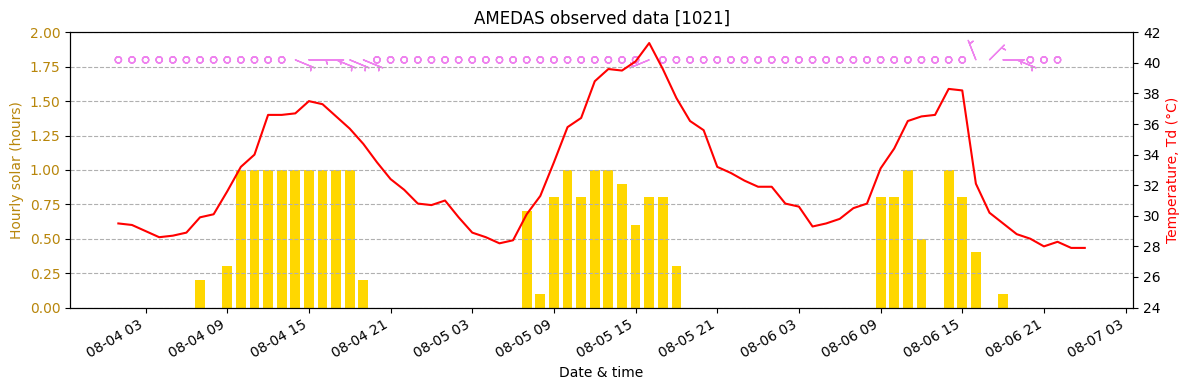

In [97]:
#### グラフ生成 ###
# 図全体構成の定義
fig, ax1 = plt.subplots(figsize=(12, 4))
#
# 1軸目の表示
if flg_RR1:  ## 棒グラフ: R1をプロット
    ax1.bar(ame_data['timestamp'], ame_data['R1'], color='skyblue', label='R1 (mm)', width=0.03)
    ax1.set_xlabel('Date & time')
    ax1.set_ylabel('R1 (mm)', color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    ax1.set_ylim(0, 40) # y軸の範囲を矢羽表示も考慮して拡大
#
if flg_G_SOLAR:  ## 棒グラフ: 全天日射量をプロット
    ax1.bar(ame_data['timestamp'], ame_data['global_solar'], color='gold', label='Global solar (MJ/M2)', width=0.03)
    ax1.set_xlabel('Date & time')
    ax1.set_ylabel('Global solar (MJ/m2)', color='darkgoldenrod')
    ax1.tick_params(axis='y', labelcolor='darkgoldenrod')
    ax1.set_ylim(0, 5) # y軸の範囲を矢羽表示も考慮して拡大
#
if flg_hourly_SOLAR:  ## 棒グラフ: 日照時間をプロット
    ax1.bar(ame_data['timestamp'], ame_data['hourly_solar'], color='gold', label='Hourly solar (hours)', width=0.03)
    ax1.set_xlabel('Date & time')
    ax1.set_ylabel('Hourly solar (hours)', color='darkgoldenrod')
    ax1.tick_params(axis='y', labelcolor='darkgoldenrod')
    ax1.set_ylim(0, 2) # y軸の範囲を矢羽表示も考慮して拡大
#
# 2軸目の表示
ax2 = ax1.twinx()
if flg_TMP: ## 折れ線グラフ: 気温をプロット（右側のy軸）
    line2, = ax2.plot(ame_data['timestamp'], ame_data['temp'], color='red', marker=None, label='Temperature (°C)')
    # ax2.plot(ame_data['timestamp'], ame_data['td'], color='green', marker=None, label='Td (℃)', linestyle='--')
    ax2.set_ylabel('Temperature, Td (°C)', color='red')
    ax2.set_ylim(24, 42) # 混合比の軸の範囲を定義
#
# if flg_PRESS: # 折れ線グラフ：海面校正気圧（右側のy軸）
#     ax2.plot(ame_data['timestamp'], ame_data['msl_press'], color='orange', marker=None, label='msl pressure (hpa)')
#     ax2.plot(ame_data['timestamp'], ame_data['press'], color='green', marker=None, label='pressure (hpa)', linestyle="--")
#     ax2.set_ylabel('Pressure (hpa)', color='black')
#
ax2.tick_params(axis='y', labelcolor='black')
# ax2.set_ylim(14, 28) # y軸の範囲を矢羽表示も考慮して拡大
# ax2.legend(loc='right', fontsize='small') # 凡例の追加
#
if flg_mx_ratio == True:
    # 3つ目のy軸（右側にさらにオフセットして追加）
    ax3 = ax1.twinx()
    #
    ax3.spines["right"].set_position(("axes", 1.08))
    line3, = ax3.plot(ame_data['timestamp'],mixing_ratio , 'g-', label='Water mixing ratio(g/kg)')
    ax3.set_ylabel('Water mixing ratio [g/kg]', color='g')
    ax3.tick_params(axis='y', labelcolor='g')
    ax3.set_ylim(15, 25) # 混合比の軸の範囲を定義
    ax3.legend(loc='lower left', fontsize='8') # 凡例の追加
#
# 4つ目のy軸
if flg_PRESS:
    ax4 = ax1.twinx()
    ax4.spines["right"].set_position(("axes", 1.15))
    ax4.plot(ame_data['timestamp'], ame_data['msl_press'], color='blue', marker=None, label='msl pressure (hpa)',
             linestyle='--')
    # ax4.plot(ame_data['timestamp'], ame_data['press'], color='green', marker=None, label='pressure (hpa)', linestyle="--")
    ax4.set_ylabel('MSL Pressure (hpa)', color='blue')
#
## アメダスの風向風速から矢羽をプロット
# 矢羽のプロットに必要なXとY方向の成分を計算 ※単位を付ける必要あり
u, v = mpcalc.wind_components(ame_data['wind'].values*units("m/s"), ame_data['wind_deg'].values*units.degrees)
# 矢羽可視化 ※降水量100mmのグリッド線上にプロットするため、ax1を指定。
ax1.barbs(ame_data['timestamp'], 1.80, u, v, length=5.5, pivot='tip', color='violet')  
# ax1.barbs(ame_data['timestamp'], 35, u, v, length=5.5, pivot='tip', color='violet')  
# ax1.barbs(ame_data['timestamp'], 4.5, u, v, length=5.5, pivot='tip', color='violet')  
#
# X軸の日付フォーマットを時間のみ (時:分) に設定
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# X軸の範囲を広げて表示 (例えば、1日分のデータ)
# ax1.set_xlim([ame_data['timestamp'].min(), ame_data['timestamp'].max()])
# X軸の目盛り間隔を1時間ごとに設定
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=6))
# y軸に目盛線を追加する
ax1.grid(axis='y', linestyle='--')  # R1軸にグリッドを合わせる
#
plt.gcf().autofmt_xdate() # x軸のラベルの配置を自動調節
if flg_kisyoudai == True: # 気象官署
    place = station.getStationName(int(block_no)) # block_no（国際地点番号）から地点名を取得
else: # アメダス
    place = f"{block_no}"
plt.title(f'AMEDAS observed data [{place}]')  # Optional: Title for the plot
plt.tight_layout()  # Optional: Adjust layout to prevent clipping of tick-labels
plt.show()

# EOF